## **1.0 Setup and Configuration**

### **1.1 Library Imports**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### **1.2 Configuration Constants**

In [ ]:
# File Path Configurations
data_root = "data"
train_list = os.path.join(data_root, "list/train.txt") # Path to the list of training image file paths 
test_list = os.path.join(data_root, "list/test.txt") # Path to the list of testing image file paths
groundtruth_file = os.path.join(data_root, "list/groundtruth.txt") # Path to the overall ground truth file
class_with_pairs_file = os.path.join(data_root, "list/class_with_pairs.txt") # Path to the list of classes that have both herbarium and field photo pairs
class_without_pairs_file = os.path.join(data_root, "list/class_without_pairs.txt") # Path to the list of classes that are only from the herbarium set

# Extracting Unique Class IDs from Training Data
labels_in_train = set()
try:
    # Open the training list file for reading
    with open(train_list, "r") as f:
        for line in f:
            # Strip whitespace and split the line
            parts = line.strip().split()
            # Check if both image path and label ID are present
            if len(parts) == 2:
                # Add the raw class ID (label) to the set to ensure uniqueness
                labels_in_train.add(int(parts[1]))
except FileNotFoundError:
    # Error handling for missing training file
    print(f"Error: Training file not found at {train_list}")
    exit()

# Get a sorted list of all unique raw class IDs found in the training data
unique_raw_labels = sorted(list(labels_in_train))
# Create a mapping dictionary: {raw_label: normalized_label}
label_map = {old_label: new_label for new_label, old_label in enumerate(unique_raw_labels)}
# Set the total number of classes required for the classification task
num_classes = 100 

# Output Summary
print(f"Found {len(unique_raw_labels)} unique species class IDs in training data.")
print(f"Model will be trained for the task's required {num_classes} species classes.")

Found 100 unique species class IDs in training data.
Model will be trained for the task's required 100 species classes.


## **2.0 Data Handling**

### **2.1 PlantDataset Class Definition**

In [ ]:
class PlantDataset(Dataset):
    """
    Handles loading of images for training (from train.txt) and testing (from test.txt and groundtruth.txt).
    """
    def __init__(self, list_file, root_dir, transform=None, train=True, label_map=None, groundtruth_file=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = [] # List to store (full_img_path, normalized_label) tuples
        self.label_map = label_map
        # Create a reverse map for potential utility
        self.reverse_label_map = {v: k for k, v in self.label_map.items()}

        if train:
            # Training data loading
            # Loads images listed in list_file (train.txt)
            with open(list_file, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 2:
                        raw_label = int(parts[1])
                        # Only include samples whose raw label exists in the label_map
                        if raw_label in self.label_map:
                            img_path = os.path.join(root_dir, parts[0])
                            # Map the raw label to the normalized integer index
                            label = self.label_map[raw_label]
                            self.samples.append((img_path, label))
        else:
            # Test/Validation data loading 
            if groundtruth_file is None or label_map is None:
                raise ValueError("groundtruth_file and label_map must be provided for test set.")

            # Load Ground Truth: Map image path to raw label ID
            test_raw_labels = {}
            with open(groundtruth_file, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 2:
                        test_raw_labels[parts[0]] = int(parts[1])

            # Load Test Images and combine with mapped labels
            with open(list_file, "r") as f:
                img_paths_relative = [line.strip() for line in f.readlines()]
            
            for img_path_relative in img_paths_relative:
                # Check if the image exists in the ground truth dictionary
                if img_path_relative in test_raw_labels:
                    raw_label = test_raw_labels[img_path_relative]
                    # Only add images belonging to a class we are training on
                    if raw_label in self.label_map:
                        full_img_path = os.path.join(root_dir, img_path_relative)
                        # Map the raw label to the normalized integer index
                        label = self.label_map[raw_label]
                        self.samples.append((full_img_path, label))
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        # Open image using PIL and ensure it's in RGB format
        image = Image.open(img_path).convert('RGB')
        # Apply the specified transformations 
        if self.transform:
            image = self.transform(image)
        return image, label

### **2.2 Data Augmentation and Transforms**

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),    # Apply random cropping and resizing.
    transforms.RandomHorizontalFlip(),  # Flip the image horizontally
    transforms.RandomRotation(15),  # Rotate the image randomly up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),   # Randomly change brightness, contrast, and saturation
    transforms.ToTensor(),  # Convert the PIL image to a PyTorch Tensor
    # Normalize the tensor using standard ImageNet mean and standard deviation
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor(),  # Convert the PIL image to a PyTorch Tensor
    # Normalize the tensor using standard ImageNet statistics
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

### **2.3 Dataset Splitting and DataLoader Setup**

In [ ]:
# Initialize Training Dataset
full_train_dataset = PlantDataset(train_list, data_root, transform=train_transform, train=True, label_map=label_map)

# Define split sizes (80% for training, 20% for validation)
TRAIN_RATIO = 0.8
train_size = int(TRAIN_RATIO * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Split the dataset
train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size])

# Initialize DataLoaders
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0) 
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0)

# Keep the original test_dataset for final evaluation
test_dataset = PlantDataset(test_list, data_root, transform=test_transform, train=False, label_map=label_map, groundtruth_file=groundtruth_file)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Full Train samples: {len(full_train_dataset)}")
print(f"New Training samples (80%): {len(train_subset)}")
print(f"New Validation samples (20%): {len(val_subset)}")
print(f"Original Test samples: {len(test_dataset)}")

Full Train samples: 4744
New Training samples (80%): 3795
New Validation samples (20%): 949
Original Test samples: 207


## **3.0 Model Architecture and Setup**

### **3.1 Model Architecture: MixStreamResnet50**

In [ ]:
class MixStreamResnet50(nn.Module):
    def __init__(self, num_classes):
        super(MixStreamResnet50, self).__init__()
        # Load a pre-trained ResNet50 model, initialized with ImageNet weights
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Freeze ALL backbone layers initially
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Unfreeze the last THREE convolutional blocks (layer4, layer3, and layer2)
        print("Unfreezing layer4, layer3, and layer2 of the backbone for fine-tuning.")
        for name, module in self.backbone.named_children():
            if name in ['layer4', 'layer3', 'layer2']: 
                for param in module.parameters():
                    param.requires_grad = True  # Enable gradients for fine-tuning

        # Replace the classifier head
        # Get the number of features output by the last convolutional layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 512),    # First linear layer reduces features from 2048 to 512  
            nn.ReLU(),
            nn.Dropout(0.5),    # Dropout regularization to prevent overfitting
            nn.Linear(512, num_classes) # Final linear layer maps 512 features to the number of species classes
        )

    # Passes the input tensor through the modified ResNet50 backbone
    def forward(self, x):
        return self.backbone(x)

### **3.2 Loss, Optimizer, and Learning Rate Scheduler**

In [ ]:
model = MixStreamResnet50(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()   # Define the loss function for multi-class classification

# Define learning rates 
ft_lr = 5e-6   # Fine-tuning learning rate for backbone layers (small)
head_lr = 5e-5 # Learning rate for the new classifier head (larger)

# Halve the L2 Regularization (Weight Decay) to prevent overly aggressive shrinkage
weight_decay = 5e-5 

# Create parameter groups for Differential Learning Rates
optimizer_parameters = [
    # Group 1: Fine-tuning layers (layer2, layer3, layer4)
    # These parameters use the smaller fine-tuning LR (ft_lr)
    {'params': list(model.backbone.layer2.parameters()) + 
               list(model.backbone.layer3.parameters()) + 
               list(model.backbone.layer4.parameters()), 
     'lr': ft_lr, 'weight_decay': weight_decay},
    
    # Group 2: Classifier head (fc)
    # These parameters use the larger head LR (head_lr)
    {'params': model.backbone.fc.parameters(), 
     'lr': head_lr, 'weight_decay': weight_decay}
]

# Optimizer
optimizer = optim.Adam(optimizer_parameters)

# Learning Rate Scheduler (ReduceLROnPlateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',       # Monitor Validation Accuracy (val_acc)
    factor=0.5,       # Reduce LR by 50%
    patience=3,       # Wait 3 epochs before reducing
)

Unfreezing layer4, layer3, and layer2 of the backbone for fine-tuning.


## **4.0 Training and Execution**

### **4.1 Model Training Execution**

In [ ]:
def validate_model(model, dataloader, criterion, device):
    """Evaluates the model on the validation dataset."""
    # Set the model to evaluation mode
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    # Disable gradient calculation for efficiency and memory savings during inference
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            # Calculate batch loss and accumulate
            running_loss += loss.item() * imgs.size(0)
            # Get the index of the max log-probability (the prediction)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            # Count the number of correct predictions
            correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy over the entire validation set
    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

# Training Loop Setup
epochs = 60
best_val_acc = 0.0
model_save_path = "best_fineTunedResnet50.pth"  # Path to save the best model weights
patience = 5    # Number of epochs to wait for improvement before early stopping
no_improve_epochs = 0   # Counter for epochs without validation accuracy improvement
train_loss_history = [] # Lists to record metrics for plotting later
val_loss_history = []
train_acc_history = []
val_acc_history = []

print("\nStarting Fine-Tuning Training...")
for epoch in range(epochs):
    # TRAINING PHASE 
    # Set the model to training mode
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_loop = tqdm(train_loader, desc=f"[Fine-Tuning] Epoch {epoch+1}/{epochs}", ncols=100)
    for imgs, labels in train_loop:
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()   # Zero the parameter gradients
        # Forward pass
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        # Backward pass (compute gradients)
        loss.backward()
        optimizer.step()
        
        # Metric aggregation
        running_loss += loss.item() * imgs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar with current batch loss and accuracy
        train_loop.set_postfix(loss=loss.item(), acc=f"{100. * correct / total:.2f}%")
        
    # Calculate epoch-level training metrics
    train_loss = running_loss / total
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    
    # VALIDATION PHASE 
    val_loss, val_acc = validate_model(model, val_loader, criterion, device)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    
    # Save best model
    save_message = ""
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_save_path)
        no_improve_epochs = 0
        save_message = "Saved best model."
    else:
        no_improve_epochs += 1
        save_message = f"No improvement for {no_improve_epochs} epoch(s)."

    # Step the scheduler based on Validation Accuracy
    scheduler.step(val_acc)
        
    # Print epoch summary
    print(
        f"Epoch [{epoch+1}/{epochs}] - "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}\n{save_message}"
    )

    # Check for early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered after {patience} epochs without improvement.")
        break

print(f"\nTraining complete. Best Validation Accuracy: {best_val_acc:.4f}")


Starting Fine-Tuning Training...


[Fine-Tuning] Epoch 1/60: 100%|█████████████| 119/119 [01:40<00:00,  1.18it/s, acc=1.95%, loss=4.68]


Epoch [1/60] - Train Loss: 4.5858 | Train Acc: 0.0195 | Val Loss: 4.5299 | Val Acc: 0.0453
Saved best model.


[Fine-Tuning] Epoch 2/60: 100%|█████████████| 119/119 [01:21<00:00,  1.46it/s, acc=4.87%, loss=4.39]


Epoch [2/60] - Train Loss: 4.4492 | Train Acc: 0.0487 | Val Loss: 4.3701 | Val Acc: 0.0664
Saved best model.


[Fine-Tuning] Epoch 3/60: 100%|█████████████| 119/119 [01:49<00:00,  1.08it/s, acc=8.85%, loss=4.04]


Epoch [3/60] - Train Loss: 4.2316 | Train Acc: 0.0885 | Val Loss: 4.1345 | Val Acc: 0.1201
Saved best model.


[Fine-Tuning] Epoch 4/60: 100%|████████████| 119/119 [00:58<00:00,  2.03it/s, acc=13.91%, loss=3.81]


Epoch [4/60] - Train Loss: 3.9612 | Train Acc: 0.1391 | Val Loss: 3.8595 | Val Acc: 0.1412
Saved best model.


[Fine-Tuning] Epoch 5/60: 100%|████████████| 119/119 [00:59<00:00,  2.00it/s, acc=17.47%, loss=3.55]


Epoch [5/60] - Train Loss: 3.6967 | Train Acc: 0.1747 | Val Loss: 3.5925 | Val Acc: 0.1812
Saved best model.


[Fine-Tuning] Epoch 6/60: 100%|████████████| 119/119 [00:59<00:00,  2.00it/s, acc=19.74%, loss=3.56]


Epoch [6/60] - Train Loss: 3.4578 | Train Acc: 0.1974 | Val Loss: 3.3545 | Val Acc: 0.2371
Saved best model.


[Fine-Tuning] Epoch 7/60: 100%|████████████| 119/119 [00:56<00:00,  2.09it/s, acc=25.19%, loss=3.59]


Epoch [7/60] - Train Loss: 3.2251 | Train Acc: 0.2519 | Val Loss: 3.1546 | Val Acc: 0.2687
Saved best model.


[Fine-Tuning] Epoch 8/60: 100%|████████████| 119/119 [00:57<00:00,  2.08it/s, acc=27.75%, loss=3.34]


Epoch [8/60] - Train Loss: 3.0317 | Train Acc: 0.2775 | Val Loss: 2.9837 | Val Acc: 0.2792
Saved best model.


[Fine-Tuning] Epoch 9/60: 100%|████████████| 119/119 [00:56<00:00,  2.10it/s, acc=32.36%, loss=3.01]


Epoch [9/60] - Train Loss: 2.8596 | Train Acc: 0.3236 | Val Loss: 2.8265 | Val Acc: 0.3224
Saved best model.


[Fine-Tuning] Epoch 10/60: 100%|███████████| 119/119 [00:58<00:00,  2.05it/s, acc=35.05%, loss=2.61]


Epoch [10/60] - Train Loss: 2.7027 | Train Acc: 0.3505 | Val Loss: 2.6955 | Val Acc: 0.3277
Saved best model.


[Fine-Tuning] Epoch 11/60: 100%|███████████| 119/119 [00:59<00:00,  1.99it/s, acc=37.23%, loss=2.59]


Epoch [11/60] - Train Loss: 2.5599 | Train Acc: 0.3723 | Val Loss: 2.5997 | Val Acc: 0.3593
Saved best model.


[Fine-Tuning] Epoch 12/60: 100%|███████████| 119/119 [00:57<00:00,  2.09it/s, acc=41.13%, loss=3.03]


Epoch [12/60] - Train Loss: 2.4065 | Train Acc: 0.4113 | Val Loss: 2.4800 | Val Acc: 0.4015
Saved best model.


[Fine-Tuning] Epoch 13/60: 100%|███████████| 119/119 [00:57<00:00,  2.07it/s, acc=43.50%, loss=1.98]


Epoch [13/60] - Train Loss: 2.2730 | Train Acc: 0.4350 | Val Loss: 2.4119 | Val Acc: 0.4099
Saved best model.


[Fine-Tuning] Epoch 14/60: 100%|███████████| 119/119 [00:57<00:00,  2.05it/s, acc=44.69%, loss=1.74]


Epoch [14/60] - Train Loss: 2.1881 | Train Acc: 0.4469 | Val Loss: 2.3118 | Val Acc: 0.4268
Saved best model.


[Fine-Tuning] Epoch 15/60: 100%|███████████| 119/119 [01:00<00:00,  1.96it/s, acc=47.75%, loss=2.21]


Epoch [15/60] - Train Loss: 2.0655 | Train Acc: 0.4775 | Val Loss: 2.2439 | Val Acc: 0.4320
Saved best model.


[Fine-Tuning] Epoch 16/60: 100%|███████████| 119/119 [00:58<00:00,  2.05it/s, acc=50.38%, loss=2.42]


Epoch [16/60] - Train Loss: 1.9679 | Train Acc: 0.5038 | Val Loss: 2.1703 | Val Acc: 0.4510
Saved best model.


[Fine-Tuning] Epoch 17/60: 100%|███████████| 119/119 [00:57<00:00,  2.08it/s, acc=52.70%, loss=1.81]


Epoch [17/60] - Train Loss: 1.8635 | Train Acc: 0.5270 | Val Loss: 2.0932 | Val Acc: 0.4816
Saved best model.


[Fine-Tuning] Epoch 18/60: 100%|███████████| 119/119 [00:56<00:00,  2.09it/s, acc=53.94%, loss=1.56]


Epoch [18/60] - Train Loss: 1.7617 | Train Acc: 0.5394 | Val Loss: 2.0451 | Val Acc: 0.4784
No improvement for 1 epoch(s).


[Fine-Tuning] Epoch 19/60: 100%|███████████| 119/119 [00:57<00:00,  2.08it/s, acc=56.42%, loss=1.46]


Epoch [19/60] - Train Loss: 1.6899 | Train Acc: 0.5642 | Val Loss: 2.0304 | Val Acc: 0.4889
Saved best model.


[Fine-Tuning] Epoch 20/60: 100%|███████████| 119/119 [01:01<00:00,  1.94it/s, acc=59.89%, loss=1.24]


Epoch [20/60] - Train Loss: 1.6019 | Train Acc: 0.5989 | Val Loss: 1.9411 | Val Acc: 0.5026
Saved best model.


[Fine-Tuning] Epoch 21/60: 100%|███████████| 119/119 [00:56<00:00,  2.11it/s, acc=61.00%, loss=1.48]


Epoch [21/60] - Train Loss: 1.5272 | Train Acc: 0.6100 | Val Loss: 1.9073 | Val Acc: 0.5100
Saved best model.


[Fine-Tuning] Epoch 22/60: 100%|███████████| 119/119 [00:56<00:00,  2.11it/s, acc=63.00%, loss=1.36]


Epoch [22/60] - Train Loss: 1.4532 | Train Acc: 0.6300 | Val Loss: 1.8640 | Val Acc: 0.5237
Saved best model.


[Fine-Tuning] Epoch 23/60: 100%|███████████| 119/119 [00:56<00:00,  2.09it/s, acc=64.53%, loss=1.41]


Epoch [23/60] - Train Loss: 1.3816 | Train Acc: 0.6453 | Val Loss: 1.8277 | Val Acc: 0.5406
Saved best model.


[Fine-Tuning] Epoch 24/60: 100%|███████████| 119/119 [00:58<00:00,  2.02it/s, acc=65.30%, loss=1.59]


Epoch [24/60] - Train Loss: 1.3450 | Train Acc: 0.6530 | Val Loss: 1.8020 | Val Acc: 0.5353
No improvement for 1 epoch(s).


[Fine-Tuning] Epoch 25/60: 100%|███████████| 119/119 [01:00<00:00,  1.96it/s, acc=66.59%, loss=1.55]


Epoch [25/60] - Train Loss: 1.2763 | Train Acc: 0.6659 | Val Loss: 1.7928 | Val Acc: 0.5406
No improvement for 2 epoch(s).


[Fine-Tuning] Epoch 26/60: 100%|███████████| 119/119 [00:58<00:00,  2.05it/s, acc=67.85%, loss=1.41]


Epoch [26/60] - Train Loss: 1.2180 | Train Acc: 0.6785 | Val Loss: 1.7202 | Val Acc: 0.5564
Saved best model.


[Fine-Tuning] Epoch 27/60: 100%|███████████| 119/119 [00:57<00:00,  2.07it/s, acc=68.64%, loss=1.02]


Epoch [27/60] - Train Loss: 1.1754 | Train Acc: 0.6864 | Val Loss: 1.7306 | Val Acc: 0.5564
No improvement for 1 epoch(s).


[Fine-Tuning] Epoch 28/60: 100%|██████████| 119/119 [00:58<00:00,  2.03it/s, acc=72.33%, loss=0.825]


Epoch [28/60] - Train Loss: 1.0847 | Train Acc: 0.7233 | Val Loss: 1.7183 | Val Acc: 0.5616
Saved best model.


[Fine-Tuning] Epoch 29/60: 100%|███████████| 119/119 [00:58<00:00,  2.05it/s, acc=72.12%, loss=1.09]


Epoch [29/60] - Train Loss: 1.0572 | Train Acc: 0.7212 | Val Loss: 1.6748 | Val Acc: 0.5796
Saved best model.


[Fine-Tuning] Epoch 30/60: 100%|███████████| 119/119 [01:01<00:00,  1.95it/s, acc=73.47%, loss=1.21]


Epoch [30/60] - Train Loss: 0.9991 | Train Acc: 0.7347 | Val Loss: 1.6364 | Val Acc: 0.5869
Saved best model.


[Fine-Tuning] Epoch 31/60: 100%|██████████| 119/119 [00:58<00:00,  2.04it/s, acc=75.26%, loss=0.718]


Epoch [31/60] - Train Loss: 0.9524 | Train Acc: 0.7526 | Val Loss: 1.6373 | Val Acc: 0.5901
Saved best model.


[Fine-Tuning] Epoch 32/60: 100%|███████████| 119/119 [01:00<00:00,  1.97it/s, acc=77.47%, loss=1.08]


Epoch [32/60] - Train Loss: 0.8963 | Train Acc: 0.7747 | Val Loss: 1.6555 | Val Acc: 0.5680
No improvement for 1 epoch(s).


[Fine-Tuning] Epoch 33/60: 100%|███████████| 119/119 [00:58<00:00,  2.03it/s, acc=76.50%, loss=1.04]


Epoch [33/60] - Train Loss: 0.8752 | Train Acc: 0.7650 | Val Loss: 1.6272 | Val Acc: 0.5859
No improvement for 2 epoch(s).


[Fine-Tuning] Epoch 34/60: 100%|███████████| 119/119 [00:56<00:00,  2.09it/s, acc=77.94%, loss=1.09]


Epoch [34/60] - Train Loss: 0.8187 | Train Acc: 0.7794 | Val Loss: 1.6306 | Val Acc: 0.5933
Saved best model.


[Fine-Tuning] Epoch 35/60: 100%|███████████| 119/119 [00:56<00:00,  2.09it/s, acc=78.79%, loss=1.12]


Epoch [35/60] - Train Loss: 0.7927 | Train Acc: 0.7879 | Val Loss: 1.6367 | Val Acc: 0.6006
Saved best model.


[Fine-Tuning] Epoch 36/60: 100%|██████████| 119/119 [00:59<00:00,  2.02it/s, acc=79.58%, loss=0.338]


Epoch [36/60] - Train Loss: 0.7502 | Train Acc: 0.7958 | Val Loss: 1.6029 | Val Acc: 0.5975
No improvement for 1 epoch(s).


[Fine-Tuning] Epoch 37/60: 100%|██████████| 119/119 [00:58<00:00,  2.05it/s, acc=81.48%, loss=0.818]


Epoch [37/60] - Train Loss: 0.6987 | Train Acc: 0.8148 | Val Loss: 1.5706 | Val Acc: 0.5996
No improvement for 2 epoch(s).


[Fine-Tuning] Epoch 38/60: 100%|███████████| 119/119 [00:59<00:00,  2.01it/s, acc=81.90%, loss=1.05]


Epoch [38/60] - Train Loss: 0.6827 | Train Acc: 0.8190 | Val Loss: 1.5618 | Val Acc: 0.6080
Saved best model.


[Fine-Tuning] Epoch 39/60: 100%|██████████| 119/119 [01:00<00:00,  1.96it/s, acc=83.27%, loss=0.821]


Epoch [39/60] - Train Loss: 0.6353 | Train Acc: 0.8327 | Val Loss: 1.5944 | Val Acc: 0.6112
Saved best model.


[Fine-Tuning] Epoch 40/60: 100%|██████████| 119/119 [00:58<00:00,  2.03it/s, acc=84.06%, loss=0.612]


Epoch [40/60] - Train Loss: 0.6245 | Train Acc: 0.8406 | Val Loss: 1.6250 | Val Acc: 0.6048
No improvement for 1 epoch(s).


[Fine-Tuning] Epoch 41/60: 100%|██████████| 119/119 [03:37<00:00,  1.83s/it, acc=84.90%, loss=0.753]


Epoch [41/60] - Train Loss: 0.5912 | Train Acc: 0.8490 | Val Loss: 1.5658 | Val Acc: 0.6175
Saved best model.


[Fine-Tuning] Epoch 42/60: 100%|██████████| 119/119 [02:16<00:00,  1.15s/it, acc=86.19%, loss=0.698]


Epoch [42/60] - Train Loss: 0.5539 | Train Acc: 0.8619 | Val Loss: 1.5787 | Val Acc: 0.6101
No improvement for 1 epoch(s).


[Fine-Tuning] Epoch 43/60: 100%|██████████| 119/119 [02:57<00:00,  1.49s/it, acc=86.61%, loss=0.792]


Epoch [43/60] - Train Loss: 0.5258 | Train Acc: 0.8661 | Val Loss: 1.5454 | Val Acc: 0.6175
No improvement for 2 epoch(s).


[Fine-Tuning] Epoch 44/60: 100%|██████████| 119/119 [03:45<00:00,  1.90s/it, acc=86.43%, loss=0.793]


Epoch [44/60] - Train Loss: 0.5198 | Train Acc: 0.8643 | Val Loss: 1.5792 | Val Acc: 0.5954
No improvement for 3 epoch(s).


[Fine-Tuning] Epoch 45/60: 100%|███████████| 119/119 [03:51<00:00,  1.94s/it, acc=87.17%, loss=0.98]


Epoch [45/60] - Train Loss: 0.4876 | Train Acc: 0.8717 | Val Loss: 1.5937 | Val Acc: 0.6122
No improvement for 4 epoch(s).


[Fine-Tuning] Epoch 46/60: 100%|██████████| 119/119 [02:56<00:00,  1.48s/it, acc=88.56%, loss=0.488]


Epoch [46/60] - Train Loss: 0.4479 | Train Acc: 0.8856 | Val Loss: 1.5996 | Val Acc: 0.6207
Saved best model.


[Fine-Tuning] Epoch 47/60: 100%|██████████| 119/119 [03:14<00:00,  1.63s/it, acc=89.20%, loss=0.334]


Epoch [47/60] - Train Loss: 0.4280 | Train Acc: 0.8920 | Val Loss: 1.5745 | Val Acc: 0.6101
No improvement for 1 epoch(s).


[Fine-Tuning] Epoch 48/60: 100%|██████████| 119/119 [03:30<00:00,  1.77s/it, acc=90.25%, loss=0.757]


Epoch [48/60] - Train Loss: 0.4135 | Train Acc: 0.9025 | Val Loss: 1.5546 | Val Acc: 0.6133
No improvement for 2 epoch(s).


[Fine-Tuning] Epoch 49/60: 100%|██████████| 119/119 [03:24<00:00,  1.72s/it, acc=88.77%, loss=0.574]


Epoch [49/60] - Train Loss: 0.4292 | Train Acc: 0.8877 | Val Loss: 1.5857 | Val Acc: 0.6207
No improvement for 3 epoch(s).


[Fine-Tuning] Epoch 50/60: 100%|██████████| 119/119 [01:48<00:00,  1.10it/s, acc=89.75%, loss=0.513]


Epoch [50/60] - Train Loss: 0.4046 | Train Acc: 0.8975 | Val Loss: 1.5476 | Val Acc: 0.6154
No improvement for 4 epoch(s).


[Fine-Tuning] Epoch 51/60: 100%|██████████| 119/119 [02:15<00:00,  1.14s/it, acc=90.43%, loss=0.502]


Epoch [51/60] - Train Loss: 0.3848 | Train Acc: 0.9043 | Val Loss: 1.5543 | Val Acc: 0.6143
No improvement for 5 epoch(s).
Early stopping triggered after 5 epochs without improvement.

Training complete. Best Validation Accuracy: 0.6207


## **5.0 Final Evaluation**

In [ ]:
# Load raw class IDs for filtering 
def load_raw_labels(file_path):
    raw_labels = set()
    try:
        with open(file_path, "r") as f:
            for line in f:
                raw_labels.add(int(line.strip()))
    except FileNotFoundError:
        print(f"Error: Required file {file_path} not found.")
        return raw_labels
    return raw_labels

# Load the raw class IDs for the two specific evaluation groups
with_pairs_raw_labels = load_raw_labels(class_with_pairs_file)
without_pairs_raw_labels = load_raw_labels(class_without_pairs_file)


# Create separate test datasets/loaders 
def create_subset_loader(dataset, target_raw_labels):
    indices = []
    # Use the reverse map to convert contiguous (normalized) labels back to raw labels
    reverse_map = dataset.reverse_label_map

    for i, (_, contiguous_label_index) in enumerate(dataset.samples):
        # Find the original (raw) label for the current sample
        raw_label = reverse_map.get(contiguous_label_index)
        # Check if this raw label is one of the target classes for this subset
        if raw_label in target_raw_labels:
            indices.append(i)   # Record the index of the sample
    
    # Create a PyTorch Subset using the collected indices
    subset = Subset(dataset, indices)
    # Create a DataLoader for the new subset
    return DataLoader(subset, batch_size=32, shuffle=False, num_workers=0)

# Use the *original* test_dataset and test_loader for final evaluation
with_pairs_loader = create_subset_loader(test_dataset, with_pairs_raw_labels)
herbarium_only_loader = create_subset_loader(test_dataset, without_pairs_raw_labels)

print(f"\nClasses With Pairs test samples: {len(with_pairs_loader.dataset)}")
print(f"Classes Herbarium Only test samples: {len(herbarium_only_loader.dataset)}")


# Define evaluation function (Top-1 and Top-5) 
def evaluate_model(model, dataloader, device, description=""):
    if len(dataloader.dataset) == 0:
        print(f"{description} — No samples available for evaluation.")
        return 0.0, 0.0

    correct_top1 = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc=f"[Eval] {description}", ncols=100):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)   # Get model predictions (logits)

            # Top-1
            _, pred_top1 = outputs.topk(1, dim=1)
            correct_top1 += pred_top1.eq(labels.view(-1, 1)).sum().item()

            # Top-5
            _, pred_top5 = outputs.topk(5, dim=1)
            labels_expanded = labels.view(-1, 1).expand_as(pred_top5)
            correct_top5 += pred_top5.eq(labels_expanded).sum().item()

            total += labels.size(0)

    # Calculate percentages
    top1_acc = 100. * correct_top1 / total
    top5_acc = 100. * correct_top5 / total
    print(f"{description} — Top-1 Acc: {top1_acc:.2f}% | Top-5 Acc: {top5_acc:.2f}%\n")
    return top1_acc, top5_acc


# Evaluate and Print Comparison 
# Load best fine-tuned model
model_save_path = "best_fineTunedResnet50.pth"

model.load_state_dict(torch.load(model_save_path))
model.eval()

print("Starting Final Evaluation on Test Set...")

# Evaluate the model on the entire test set
overall_top1, overall_top5 = evaluate_model(model, test_loader, device, "Overall Test Set")

# Evaluate on the two specialized subsets
with_pairs_top1, with_pairs_top5 = evaluate_model(model, with_pairs_loader, device, "Classes With Pairs")
herbarium_top1, herbarium_top5 = evaluate_model(model, herbarium_only_loader, device, "Classes Herbarium Only")

print("Performance Comparison:")
print(f"Overall Test Set — Top-1: {overall_top1:.2f}% | Top-5: {overall_top5:.2f}%")
print(f"Classes With Pairs — Top-1: {with_pairs_top1:.2f}% | Top-5: {with_pairs_top5:.2f}%")
print(f"Classes Herbarium Only — Top-1: {herbarium_top1:.2f}% | Top-5: {herbarium_top5:.2f}%")

# Conclusion 
if with_pairs_top1 > herbarium_top1:
    print("\n**Conclusion: The model performs better on species that were trained with paired (field + herbarium) data.**")
else:
    print("\n**Conclusion: The model performs better on species that were trained with herbarium-only data.**")


Classes With Pairs test samples: 153
Classes Herbarium Only test samples: 54
Starting Final Evaluation on Test Set...


[Eval] Overall Test Set: 100%|████████████████████████████████████████| 7/7 [00:03<00:00,  1.76it/s]


Overall Test Set — Top-1 Acc: 48.79% | Top-5 Acc: 62.80%



[Eval] Classes With Pairs: 100%|██████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


Classes With Pairs — Top-1 Acc: 65.36% | Top-5 Acc: 83.66%



[Eval] Classes Herbarium Only: 100%|██████████████████████████████████| 2/2 [00:00<00:00,  2.58it/s]

Classes Herbarium Only — Top-1 Acc: 1.85% | Top-5 Acc: 3.70%

Performance Comparison:
Overall Test Set — Top-1: 48.79% | Top-5: 62.80%
Classes With Pairs — Top-1: 65.36% | Top-5: 83.66%
Classes Herbarium Only — Top-1: 1.85% | Top-5: 3.70%

**Conclusion: The model performs better on species that were trained with paired (field + herbarium) data.**


## **6.0 Visualization of Training History**

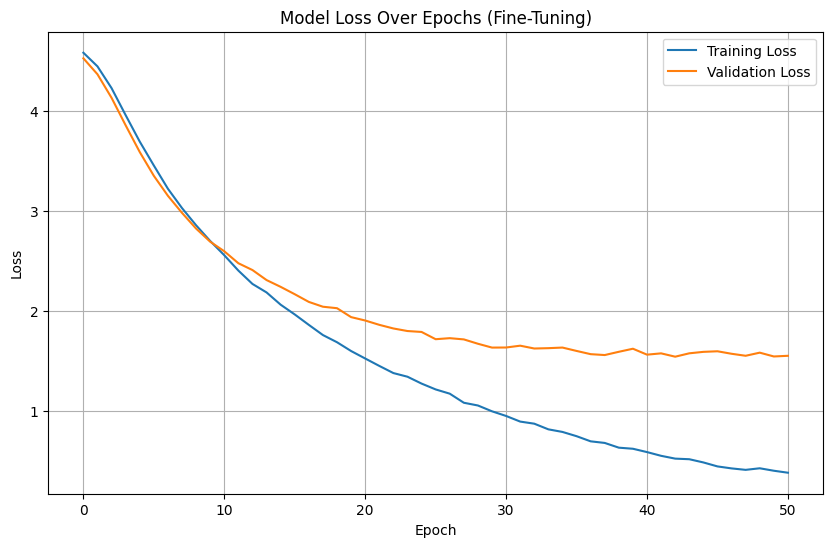

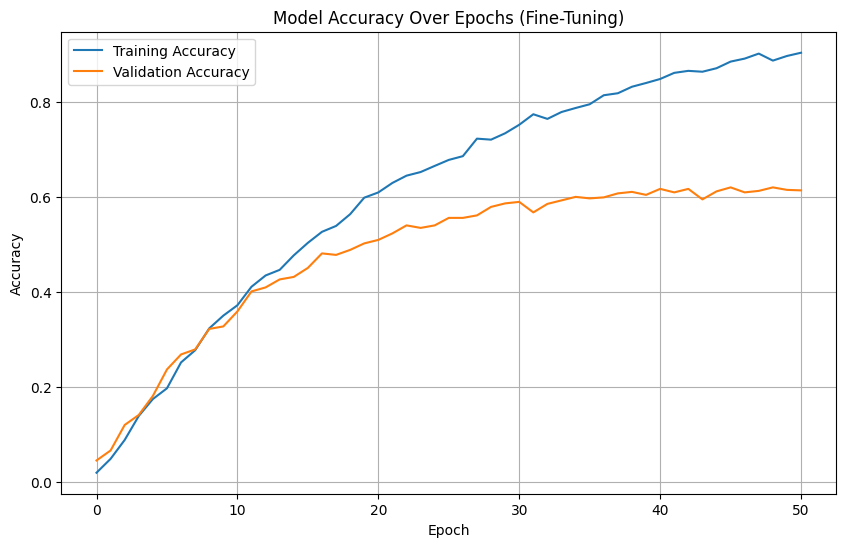

In [ ]:
# Plot the training and validation history for a given metric over epochs
def plot_history(train_history, val_history, metric_name, filename):
    plt.figure(figsize=(10, 6))
    plt.plot(train_history, label=f'Training {metric_name}')
    plt.plot(val_history, label=f'Validation {metric_name}')
    plt.title(f'Model {metric_name} Over Epochs (Fine-Tuning)')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show() 

# Plotting the collected metrics
plot_history(train_loss_history, val_loss_history, 'Loss', 'fine_tuned_loss_history.png')   # Plot loss curve
plot_history(train_acc_history, val_acc_history, 'Accuracy', 'fine_tuned_acc_history.png')  # Plot accuracy curve